In [3]:
import sys

import tensorflow.keras
# import pandas as pd
# import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
# print(f"Pandas {pd.__version__}")
# print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
GPU is available


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import tensorflow as tf
from tensorflow import keras as keras

In [6]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape

(404, 13)

In [7]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The targets are median values of owner-occupied homes, in thousands of dollars

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

It would be problematic to feed such values directly into neural network, because they all take wildly different ranges. This is making learning more difficult. 

Thus, we are forced to do waht is called feature-wise normalisation; for each feature, we are subtracting the mean and then we are dividing that by the standard deviation, so that the feature is centered around 0 and has a standard deviation

In [9]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Since we have already a small sample, we will use a small neural network, with two hidden layers, each with 64 units. This is because less training data means more overfitting, and having less layers is one way to mitigate this.

The last layer ends with a single unit and no activation. This is typical for scalar regression (regression where we are predicting a single continuous value). 

The metrics we are using are mean absolute error (mae). It is the absolute value of difference between targets and the prediction. For example, if it was 0.5, that means our predictions are off by $500

In [10]:
import numpy as np

k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
print(num_val_samples)

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model_0 = build_model()
    model_0.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)

    val_mse, val_mae = model_0.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

    all_scores

101
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Since we already have very limited data to go off, it would be inadvisable to split the data further into validation and training. Therefore we are using a method known as K-fold cross-validation. It is involving the splitting of the data into K partitions (where K is usually 4 or 5) and training on each partition, whilst evaluating on the others. We would then average the validation score each time, to get the average.

In [11]:
np.mean(all_scores)

2.2756401896476746

Hence, on average, we are off by $2606, which is a significant value. We can try to improve this by using 500 epochs. We should also adjust the model building formula to record the valiidatoin score each time, so we can construct a graph later

In [12]:
history = model_0.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
for x in history.history:
    print(x)

loss
mae


In [16]:
assert tf.test.is_built_with_gpu_support()
assert tf.test.is_built_with_cuda()

In [18]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model_0 = build_model()
    history = model_0.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)
    all_mae_histories

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

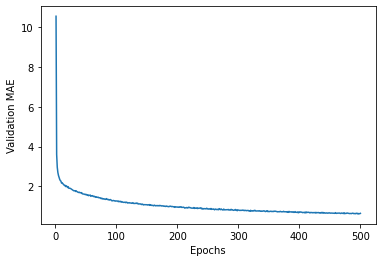

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [21]:
for x in history.history:
    print(x)

loss
mae


In [23]:
history.history

{'loss': [202.04884338378906,
  28.581125259399414,
  19.95682144165039,
  16.536720275878906,
  14.994813919067383,
  13.739720344543457,
  12.757389068603516,
  12.107682228088379,
  11.712342262268066,
  10.929998397827148,
  11.11219310760498,
  10.481954574584961,
  10.380875587463379,
  9.858572959899902,
  10.063647270202637,
  10.053318977355957,
  9.483582496643066,
  9.208413124084473,
  9.283905982971191,
  9.093803405761719,
  9.22816276550293,
  8.060497283935547,
  8.66526985168457,
  8.364365577697754,
  8.349153518676758,
  8.313695907592773,
  7.4524030685424805,
  7.997183322906494,
  8.1816987991333,
  7.563148498535156,
  7.570262432098389,
  7.4531965255737305,
  6.884388446807861,
  7.29544734954834,
  7.597672939300537,
  7.389265537261963,
  6.910593032836914,
  6.927543640136719,
  6.727875232696533,
  6.239651203155518,
  6.728220462799072,
  6.504597187042236,
  6.365781307220459,
  5.925498008728027,
  6.265423774719238,
  5.73674201965332,
  6.1204729080200